In [ ]:
%matplotlib inline  
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors.kde import KernelDensity
from scipy.stats.distributions import norm
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from pprint import pprint
from functools import partial
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import arff
import pandas as pd
import numpy as np
import time

In [2]:
def visualize_atom(df, labels):
    fig = pyplot.figure()
    ax = Axes3D(fig)

    ax.scatter(df['x'], df['y'], df['z'], c=labels)
    pyplot.show()
    
def visualze_vehicle(df, labels):
    pca = PCA(n_components=2)
    reduced_dim_data = pca.fit_transform(df.drop('class', axis=1))
    class_group = pd.DataFrame(
        {
            'x': reduced_dim_data[:, 0], 
            'y': reduced_dim_data[:, 1],
            'class': labels
        }
    ).groupby('class')

    fig, ax = plt.subplots()
    for name, group in class_group:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
    ax.legend()

    plt.show()

In [3]:
path_visual = {
    'data/atom.arff': visualize_atom,
    'data/vehicle.arff': visualze_vehicle
}
PATH_N_CLUST = {
    'data/atom.arff': [2],
    'data/vehicle.arff': [4]
}

In [4]:
def get_df(arff_path):
    dataset = arff.load(open(arff_path, 'r'))
    print(dataset['attributes'])
    attributes = [a[0].lower() for a in dataset['attributes']]
    return pd.DataFrame(dataset['data'], columns=attributes)

In [5]:
def clustering_summary(classes, labels, visual_partial):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    result = {
        'est_number_of_clusters': n_clusters,
        'homogenity': metrics.homogeneity_score(classes, labels),
        'completeness': metrics.completeness_score(classes, labels),
        'v_measure': metrics.v_measure_score(classes, labels),
        'adjusted_rand_score': metrics.adjusted_rand_score(classes, labels),
        'adjusted_mutual_info_score': metrics.adjusted_mutual_info_score(classes, labels)
    }
    pprint(result)
    
    visual_partial(labels)
    
    return result
###partial(visualizer, df)

In [6]:
def eval_dbscan(df, visualizer):
    # http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
    metric_names = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    for metric_name in metric_names:
        db = DBSCAN(eps=10, min_samples=10, metric=metric_name, p=2).fit(df.drop('class', axis=1))
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        print(metric_name)
        clustering_summary(df['class'], labels, visualizer)
        print('')


In [7]:
def eval_agglomerative(df, visualizer, n_clusters):
    metrics_agglomerative = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2']
    for metric_agglomerative  in metrics_agglomerative:
        for n_clusters in n_clusters:
            for linkage in ('average', 'complete'):
                model = AgglomerativeClustering(linkage=linkage,
                                                affinity=metric_agglomerative,
                                                connectivity=None,
                                                n_clusters=n_clusters)
                model.fit(df.drop('class', axis=1))
                core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
                labels = model.labels_

                print(metric_agglomerative)
                print("linkage: {}".format(linkage))
                clustering_summary(df['class'], labels, visualizer)
                print('')


data/atom.arff <function visualize_atom at 0x7f267dfef730>
[('x', 'REAL'), ('y', 'REAL'), ('z', 'REAL'), ('class', ['1', '2'])]
=== ground truth ===


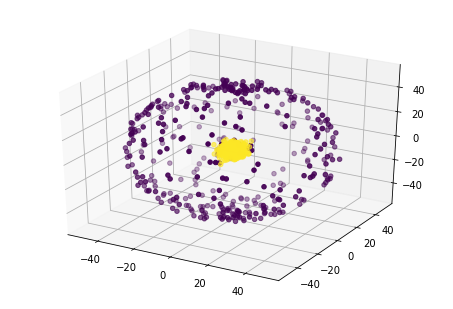

=== dbscan ===
euclidean
{'adjusted_mutual_info_score': 0.65835603277722587,
 'adjusted_rand_score': 0.80290477651631387,
 'completeness': 0.65896983759490024,
 'est_number_of_clusters': 3,
 'homogenity': 0.99999999999999933,
 'v_measure': 0.79443257214398166}


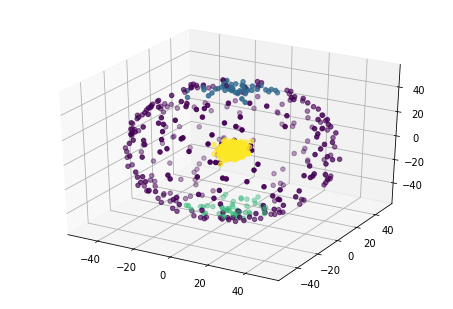


manhattan
{'adjusted_mutual_info_score': 0.70306853280297155,
 'adjusted_rand_score': 0.84784939200242937,
 'completeness': 0.703639786890631,
 'est_number_of_clusters': 3,
 'homogenity': 1.0,
 'v_measure': 0.82604291388952256}


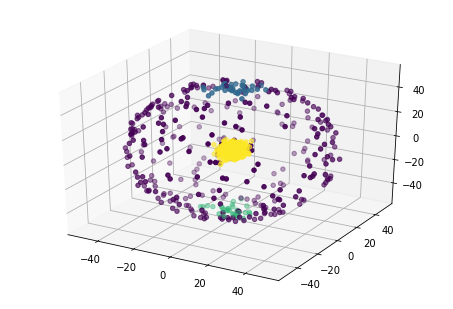


chebyshev
{'adjusted_mutual_info_score': 0.45924419848308096,
 'adjusted_rand_score': 0.64092073941893313,
 'completeness': 0.46133763942229994,
 'est_number_of_clusters': 9,
 'homogenity': 1.0,
 'v_measure': 0.63139089417374783}


In [ ]:
for path, visual in path_visual.items():
    print('===============================')
    print(path, visual)
    df = get_df(path)
    
    print('=== ground truth ===')
    visual(df, df['class'])
    
    visualizer = partial(visual, df)
    print('=== dbscan ===')
    eval_dbscan(df, visualizer)
    print('=== agglomerative ===')
    eval_agglomerative(df, visualizer, PATH_N_CLUST[path])

In [ ]:
df= get_df('data/vehicle.arff')

In [ ]:
df.head()

In [ ]:

         
visualze_vehicle(df, df['class'])

In [ ]:
# https://stackoverflow.com/questions/5529625/is-it-possible-to-specify-your-own-distance-function-using-scikit-learn-k-means

In [ ]:
x_grid = np.linspace(-4.5, 3.5, 2)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
log_pdf = kde.score_samples(x)
pdf = np.exp(log_pdf)
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='test')
